# Introduction

The European Transaction Log (EUTL) is the backbone of the European Union Emissions Trading System (EUETS). It implements the transfer of emission allowances between parties active in the EUETS. The EUTL provides data on regulated installations, their emissions as well as transfers of allowances.  

Assuming that the database has been successfully populated with the EUTL data (see 1_create_database.ipynb), this notebook illustrates how to analyze compliance and transactions of a single installation.

As a starting point, we assume that the installation identifier is known. The most easy way to find the identifier is going to www.EUETS.INFO/installations and use the search field.

Specifically, we consider the Niederaussem Power Station with installation identifier DE_1649. To analyze another installation, simply change the assignment determining the installation identifier (but the text most likely no longer fits;).

The analysis takes place in three steps:
1. Use the installation identifier to get the installation object.
2. The installation object provides methods to obtain compliance and surrendering details as well as associated accounts
3. Account objects provide methods to assess related transactions.

In [1]:
id_inst = "DE_1649"

# Packages and options

In [2]:
from pyeutl.orm import DataAccessLayer    # data access layer to access the database
from pyeutl.orm import Installation       # EUETS Installation object
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Database connection settings

In [3]:
connectionSettings = dict(
    user="eutlAdmin", 
    host="localhost", 
    db="eutl_orm", 
    passw="1234",
    port=5432
)

# Connect to database

Connect to database and get a session:

In [4]:
dal = DataAccessLayer(**connectionSettings)
session = dal.session

# Get installation

Given the installation id, use the session to query the installation:

In [5]:
inst = session.query(Installation).get(id_inst)
print(inst.id + ": " + inst.name)
print(inst.address)

DE_1649: Kraftwerk Niederaußem
Werkstraße
50129 Bergheim
Germany


# Analyze compliance

Compliance is a property of the installation. For convenience, .get_compliance() provides the compliance as pandas DataFrame. 

Due to linking with the Swiss Emissions Trading System, compliance might be reported in the Swiss system. Since is the case only for aircraft operators, we simply drop the respective column: 

In [9]:
inst.compliance
df_compliance = inst.get_compliance().drop("reportedInSystem_id", axis=1)
df_compliance.head(2)

,penalty,surrenderedCummulative,verifiedUpdated,verifiedCummulative,allocated10c,allocatedNewEntrance,compliance_id,installation_id,balance,surrendered,verified,allocatedTotal,allocatedFree,euetsPhase,year,compliance
0,None,29734760.0,True,29734760.0,None,NaN,A,DE_1649,None,29734760.0,29734760.0,28667044,28667044.0,2005-2007,2005,The number of allowances and ERUs/CERs surrend...
1,None,57121443.0,True,57121443.0,None,NaN,A,DE_1649,None,27386683.0,27386683.0,28667044,28667044.0,2005-2007,2006,The number of allowances and ERUs/CERs surrend...


To get a first impression, plot compliance, i.e., allocated and surrendered allowances and verified emissions over time:

<AxesSubplot:xlabel='year', ylabel='Million tCO$_2$'>

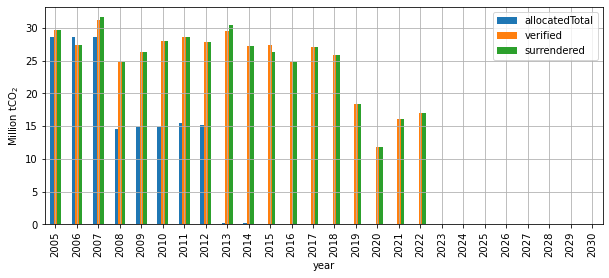

In [10]:
df_compliance[["year", "allocatedTotal", "verified", "surrendered"]]\
    .set_index("year").div(1000000)\
    .plot(kind="bar", figsize=(10,4), ylabel=r"Million tCO$_2$", grid=True)

The plot provides three main insights: First, in all years, surrendered allowances equaled or exceeded verified emissions, i.e., the installation was always compliant. Second, emissions remained rather constant between 2005 and 2012 although showing some annual variations. From 2013 onwards, emissions seem to show a decreasing trend. Third, in the first (second) EUETS period, the installation received about 25 (15) million allowances for free but received no free allocation after 2012. Irrespective of free allocation, the installation was in need to acquire additional allowances from 2008 onwards, i.e., verified emissions always exceeded free allocation.

# Surrendering

The installation was in need to acquire additional allowances to be compliant with the EUETS. This offers the question, which allowances have been surrendered. For the first two periods (2005-2007, 2008-2012) the EUTL reports the type of allowances surrendered (e.g., EUA, CER, ERU) as well as the country in which the surrendered certificate has been created. 

Technically, surrendering unit details are also accessible through the installation object (property: surrendering) and the method get_surrendering() provides a Pandas dataframe:

For periods prior to 2013 we observe the country of origin for surrendered units: 

originatingRegistry_id
AT      0.003655
BE      0.534571
BG      0.002657
CZ      0.595094
DE    163.078244
DK      0.014600
EE      0.000330
ES      1.264313
FI      0.044167
FR      0.170644
GB      0.888548
IE      0.013412
NL      0.396262
NO      0.081062
SK      0.107795
dtype: float64

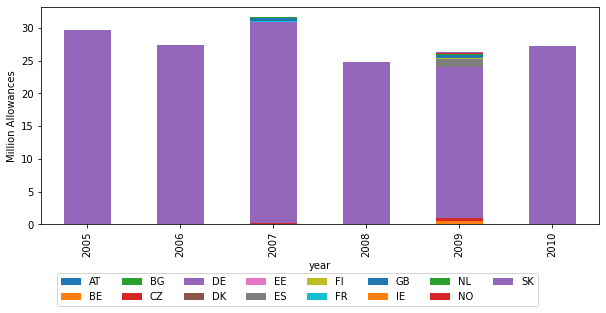

In [11]:
df_p = (inst.get_surrendering()[["year", "originatingRegistry_id", "amount"]]
        .pivot_table("amount", "year", "originatingRegistry_id")
        .div(1000000)
       )

ax = df_p.plot(kind="bar", stacked=True,  figsize=(10,4),)
ax.legend(bbox_to_anchor=(0.9, -0.2), loc=0, ncol=8)
ax.set_ylabel("Million Allowances")
df_p.sum()

# Accounts

Our installation shows some variety of allowances used for surrendering. We now turn to the question, how the installation acquired these allowances. To find an answer to this this questions, we need to examine the transaction behavior of related <i>Accounts</i>.

The EUETS implements emissions trading. Industrial plants regulated are called <i>Installations</i>. Each installation has to be related to an accounts. These accounts might (and are likely to) change over time but at each instance in time an installation is represented by an account. Accounts are the backbone of the trading system, i.e., allowances are transferred between accounts not between installations. Accounts related to installations are called operator holding accounts. As transfers of allowances take place at the account level, we need to find out which accounts represent our installation.

Technically, related accounts are again implemented as property on the installation object (property: accounts). Accounts related to installations are called operator holding accounts (oha):

In [12]:
ohas = inst.accounts
ohas

[<Account(104791, '1667 - Anlagenkonto', 'DE', '100-7')>,
 <Account(2501, '1667 - Anlagenkonto', 'DE', '120-0')>]

There are two different accounts. 120-0 denotes former operator holding accounts whereas 100-7 denotes the operating holding account. This account structure is common for installations that have been regulated under the EUETS already before 2013. Due to the change in the EUTL, all installation had to convert their account from 120-0 to 100-7 accounts. Consequently, our 2005 analysis has to focus in the 120-0 account with the meaningful name "Operator Account".

## Getting transactions

Transactions are provided as property on the respective account (property: transactions). To separate transaction by whether the selected account is acquiring or transferring allowances, separate transactions exist (acquiringTransactions, transferringTransactions). get_transactions() provides again a Pandas dataframe with transaction by the respective account.

In [13]:
df_trans = ohas[1].get_transactions()
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153 entries, 2005-04-04 16:55:33 to 2012-04-26 11:35:58
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   unitType_id                      153 non-null    object
 1   project_id                       0 non-null      object
 2   acquiringYear                    0 non-null      object
 3   amount                           153 non-null    int64 
 4   transferringYear                 0 non-null      object
 5   transactionTypeMain_id           153 non-null    int64 
 6   transactionTypeSupplementary_id  153 non-null    int64 
 7   transferringAccount_id           153 non-null    int64 
 8   transactionID                    153 non-null    object
 9   acquiringAccount_id              153 non-null    int64 
 10  id                               153 non-null    int64 
 11  tradingSystem_id                 153 non-null    object
 12 

Given that we look at an former operator holding accounts, we observe transactions between 2005 and 2012. Overall we observe over 200 entries in the transaction data. However, that does not mean that the transaction was involved in 200 transactions. If a transaction involves different unit types or units from different origins, this is reported as a row in the transaction data. To see the number of transactions carried out, we count the number of transactionIDs as provided by the EUTL: 

In [14]:
print("Number of transactions: %d" % len(df_trans["transactionID"].unique()))

Number of transactions: 43


So only 50 transactions have been carried out. Before continuing to analyze the first year of transaction activities, we show how to calculate allowance holdings over time.

## Allowances holdings

The dataframe contains a column "direction" which equals 1 if the account is acquiring and -1 if the account is transferring allowances. The column "amount_directed" contains the amount of each transaction multiplied by the direction. We can use it plot transfers over time and also the cumulative allowance holding:

(12748.766339699074, 15585.422213541668)

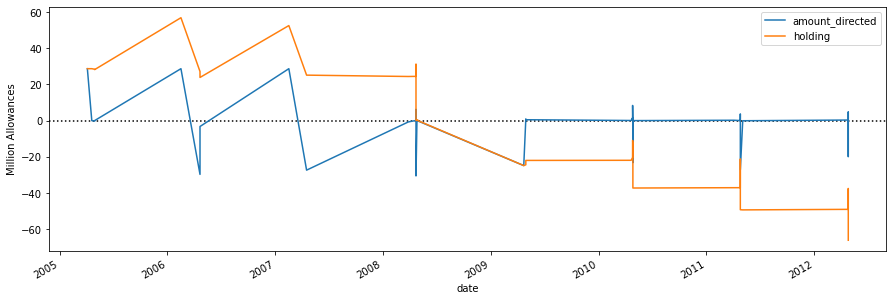

In [16]:
df_ = df_trans[["amount_directed"]]/1000000
df_["holding"] = df_.amount_directed.cumsum()
ax = df_.plot( figsize=(15,5), ylabel="Million Allowances")
lims = ax.get_xlim()
ax.hlines(0, *lims, colors="k", ls=":")
ax.set_xlim(*lims)
#df_

We observe a rather typical pattern. End of February, the account receives a large amount of allowances (blue line). This is primary allocation of allowances. It is followed by a large negative transfer which marks surrendering of allowances. In between we observe further transactions which might be market transaction, transactions within the company, etc. Allowance holding naturally follows transactions. Surprisingly, allowance holding turns negative at some point in time, which is legally impossible. Here it seems that we are missing some transactions.

## Transactions

Lets finally take a closer look at transactions until the first surrendering of allowances that took place beginning of April 2006. We do not aim to track the origin of allowances and, thus, aggregate data to transactions that took place

In [17]:
df_trans_2005 = df_trans[:"2006/04/30"]
df_trans_2005.reset_index().groupby(
    ["date", "transactionID", "transactionTypeMain", "transactionTypeSupplementary",
     "transferringAccountName", "transferringAccountType",
     "acquiringAccountName", "acquiringAccountType"], as_index=False)\
    .amount_directed.sum().set_index("date").sort_index()

,transactionID,transactionTypeMain,transactionTypeSupplementary,transferringAccountName,transferringAccountType,acquiringAccountName,acquiringAccountType,amount_directed
date,,,,,,,,
2005-04-04 16:55:33,DE258,Internal - Internal transfer of unit/supplemen...,Allowance allocation,Nationalkonto - Ausgabe,Party Holding Account,1667 - Anlagenkonto,Former Operator Holding Account,28667044
2006-02-15 19:47:42,DE5541,Internal - Internal transfer of unit/supplemen...,Allowance allocation,Nationalkonto - Ausgabe,Party Holding Account,1667 - Anlagenkonto,Former Operator Holding Account,28667044
2006-04-21 10:11:11,DE7509,Internal - Internal transfer of unit/supplemen...,Allowance surrender,1667 - Anlagenkonto,Former Operator Holding Account,Nationalkonto - Abgabe,Party Holding Account,-29734760


In the first transactions, the operator account received allowances from the regulator (allocation). Likewise free allowances for the year 2006 have been booked at 2006/02/15.

On 2006/04/21 allowances equal to verified emissions in the year 2005 (see above) have been surrendered and the installation was, thus, compliant.

# Conclusions

This notebook shows how the EUTL database provided by EUETS.INFO can be used to analyze compliance and transaction behavior of a single installation. The analysis takes place in three steps:
1. Use the installation identifier to get the installation object.
2. The installation object provides methods to obtain compliance and surrendering details as well as associated accounts
3. Account objects provide methods to assess related transactions.